**Copyright 2021 Commplax authors**

Licensed under the Apache License, Version 2.0 (the "License");

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Training static Digital Backpropogation (DBP) variants with adaptive equalizer layers

```
                       ▲                       ▲
                       │                       │
       ┌───────┐   ┌───┴───┐    ┌──────┐   ┌───┴────┐
──────►│  DBP  ├──►│  FOE  ├─┬─►│ Conv ├──►│  MIMO  ├───┬─┬─►
       └───────┘   └───┬───┘ │  └──────┘   └───┬────┘   │ │
           ▲           │     │     ▲           │        │ │
           │        adaptive │     │        adaptive    │ │
       backprop        │     │  backprop       │        │ │
           │           └─────┘     │           └────────┘ │
           │                       │                      │
           └───────────────────────┴──────────────────────┘
```

## Install dependencies

In [1]:
# !pip install --upgrade jax==0.2.13 jaxlib==0.1.66+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html # optional GPU lib
!pip install --upgrade https://github.com/remifan/commplax/archive/master.zip  # commplax
!pip install --upgrade https://github.com/remifan/labptptm2/archive/master.zip # dataset API
#  might need to restart runtime on finish in Colab

     | 358kB 814kB/s
     |████████████████████████████████| 184kB 4.1MB/s 
     |████████████████████████████████| 122kB 15.1MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for commplax: filename=commplax-0.1.1-cp37-none-any.whl size=48543 sha256=ba44eacc3a149e9227d49bd611856fae0feeccd61dc4e8ef443eac7c17674411
  Stored in directory: /tmp/pip-ephem-wheel-cache-5se9hpbl/wheels/8e/34/40/089436efd89cf5562b1cf8494af70fe11afd2b6afc030beeb8
  Created wheel for quantumrandom: filename=quantumrandom-1.9.0-cp37-none-any.whl size=9132 sha256=aac9afde85bc4f6b57bc22773bc7dd2814802718bc1112a4e9c73d4b5cb9deb9
  Stored in directory: /root/.cache/pip/wheels/8b/de/bc/12078c164eb001e81d04661804325d0e153fa2881953fd8610
Successfully built commplax quantumrandom
     / 737kB 1.1MB/s
     |████████████████████████████████| 645kB 4.3MB/s 
     |████████████████████████████████| 4.6MB 8.7MB/s 
     |████████████████████████████████| 296kB 39.2MB/s 
     |███████████████████████████

## Loading data from LabPtPTm2 datasets

In [2]:
import numpy as np
from collections import namedtuple
from commplax import comm
import labptptm2

Dataset = namedtuple('Data', ['y', 'x', 'w0', 'a'])

labptptm2.config(supdata=True, dump_dir='./dataset')
labptptm2.get([1, 2], 0, 4, 1) # 1 dBm

def loaddata(src: int, lp: int, ch: int, rep: int, num=1500000):
    ''' dataloader of LabPtPTm2 dataset
        more info: https://github.com/remifan/LabPtPTm2

        Args:
            src: QRBS source index
            lp: launched power in dBm
            ch: channel index
            rep: index of scope captures
            num: number of symbols to load

        Returns:
            dataset stored in namedtuple: (2 sample/symbol waveforms,
                                           aligned sent symbols,
                                           monitored initial FO,
                                           data attributes)
    '''

    with labptptm2.file(src, lp, ch, rep) as fd:
        y = fd['recv'][:num * 2]
        x = fd['sent'][:num]
        a = dict(zip(fd.attrs.keys(), fd.attrs.values())) # extract hdf attributes
    y -= np.mean(y, axis=0) # block DC
    y = comm.normpower(y, real=True) / np.sqrt(2) # normalize power
    x /= comm.qamscale(a['modformat']) # rescale ground truth

    with labptptm2.file(src, lp, ch, rep, supdata=True) as fd:
        nfo = fd['nfo'][...] # coarsely monitored frequency offset evolution normalized to sample period
        a['CD'] = fd.attrs['cd'] # measured CD

    w0 = nfo[0] * 2 # initial FO at symbol period used to initialize FOE

    return Dataset(y, x, w0, a)

ds_train, ds_test = loaddata(1, 0, 4, 1), loaddata(2, 0, 4, 1)

downloading data:   0%|          | 0/2 [00:00<?, ?it/s]

## Defining models, training and testing

In [3]:
from jax import numpy as jnp, random, jit, value_and_grad
import flax
from commplax import util, comm, cxopt, op
from commplax.module import core, layer
import numpy as np
from functools import partial
from collections import namedtuple
from tqdm.auto import tqdm
from typing import Any, Optional, Union


Model = namedtuple('Model', 'model initvar overlaps')
Array = Any
Dict = Union[dict, flax.core.FrozenDict]


def make_base_model(steps: int = 3,
                    dtaps: int = 261,
                    ntaps: int = 41,
                    rtaps: int = 61,
                    init_fn: tuple = (core.delta, core.gauss),
                    w0 = 0.,
                    mode: str = 'train'):
    '''
    model structure: DBP variants (backprop optim.) + 
                     adaptive Kalman-filter based FOE (self updating) + 
                     residual static filter (backprop optim.) + 
                     adaptive DDLMS-MIMO (self updating)
    make base model that derives DBP, FDBP, EDBP, GDBP depending on
    specific initialization method and trainable parameters defined
    by trainer.

    Args:
        steps: GDBP steps/layers
        dtaps: D-filter length
        ntaps: N-filter length
        rtaps: R-filter length
        init_fn: a tuple contains a pair of initializer for D-filter and N-filter
        mode: 'train' or 'test'

    Returns:
        A layer object
    '''

    _assert_taps(dtaps, ntaps, rtaps)

    d_init, n_init = init_fn

    if mode == 'train':
        # configure mimo to its training mode
        mimo_train = True
    elif mode == 'test':
        # mimo operates at training mode for the first 200000 symbols,
        # then switches to tracking mode afterwards
        mimo_train = cxopt.piecewise_constant([200000], [True, False])
    else:
        raise ValueError('invalid mode %s' % mode)

    base = layer.Serial(
        layer.FDBP(steps=steps,
                   dtaps=dtaps,
                   ntaps=ntaps,
                   d_init=d_init,
                   n_init=n_init),
        layer.BatchPowerNorm(mode=mode),
        layer.MIMOFOEAf(name='FOEAf',
                        w0=w0,
                        train=mimo_train,
                        preslicer=core.conv1d_slicer(rtaps),
                        foekwargs={}),
        layer.vmap(layer.Conv1d)(name='RConv', taps=rtaps),  # vectorize column-wise Conv1D
        layer.MIMOAF(train=mimo_train))  # adaptive MIMO layer
    return base


def _assert_taps(dtaps, ntaps, rtaps, sps=2):
    ''' we force odd taps to ease coding '''
    assert dtaps % sps, f'dtaps must be odd number, got {dtaps} instead'
    assert ntaps % sps, f'ntaps must be odd number, got {ntaps} instead'
    assert rtaps % sps, f'rtaps must be odd number, got {rtaps} instead'


def fdbp_init(a: dict,
              xi: float = 1.1,
              steps: Optional[int] = None):
    '''
        initializer for the base model

        Args:
            xi: NLC scaling factor
            steps: GDBP steps, used to calculate the theoretical profiles of D- and N-filters

        Returns:
            a pair of functions to initialize D- and N-filters
    '''

    def d_init(key, shape, dtype=jnp.complex64):
        dtaps = shape[0]
        d0, _ = comm.dbp_params(
            a['samplerate'],
            a['distance'] / a['spans'],
            a['spans'],
            dtaps,
            a['lpdbm'] - 3,  # rescale as input power which has been norm to 2 in dataloader
            virtual_spans=steps)
        return d0[0, :, 0]

    def n_init(key, shape, dtype=jnp.float32):
        dtaps = shape[0]
        _, n0 = comm.dbp_params(
            a['samplerate'],
            a['distance'] / a['spans'],
            a['spans'],
            dtaps,
            a['lpdbm'] - 3,  # rescale
            virtual_spans=steps)

        return xi * n0[0, 0, 0] * core.gauss(key, shape, dtype)

    return d_init, n_init


def model_init(data: Dataset,
               base_conf: dict,
               sparams_flatkeys: list,
               n_symbols: int = 2000,
               sps : int = 2):
    ''' initialize model from base template, generating CDC, DBP, EDBP, FDBP, GDBP
    depending on given N-filter length and trainable parameters

    Args:
        data:
        base_conf: a dict of kwargs to make base model, see `make_base_model`
        sparams_flatkeys: a list of keys contains the static(nontrainable) parameters.
            For example, assume base model has parameters represented as nested dict
            {'color': 'red', 'size': {'width': 1, 'height': 2}}, its flatten layout is dict
             {('color',): 'red', ('size', 'width',): 1, ('size', 'height'): 2}, a sparams_flatkeys
             of [('color',): ('size', 'width',)] means 'color' and 'size/width' parameters are static.
            regexp key is supportted.
        n_symbols: number of symbols used to initialize model, use the minimal value greater than channel
            memory
        sps: sample per symbol. Only integer sps is supported now.

    Returns:
        a initialized model wrapped by a namedtuple
    '''

    model = make_base_model(**base_conf, w0=data.w0)
    y0 = data.y[:n_symbols * sps]
    rng0 = random.PRNGKey(0)
    z0, v0 = model.init(rng0, core.Signal(y0))
    ol = z0.t.start - z0.t.stop
    sparams, params = util.dict_split(v0['params'], sparams_flatkeys)
    state = v0['af_state']
    aux = v0['aux_inputs']
    const = v0['const']
    return Model(model, (params, state, aux, const, sparams), ol)


def loss_fn(model: layer.Layer,
            params: Dict,
            state: Dict,
            y: Array,
            x: Array,
            aux: Dict,
            const: Dict,
            sparams: Dict):
    ''' loss function

        Args:
            model: model returned by `model_init`
            params: trainable parameters
            state: model state
            y: transmitted waveforms
            x: aligned sent symbols
            aux: auxiliary input
            const: contants (internal info generated by model)
            sparams: static parameters

        Return:
            loss, updated model state
    '''

    params = util.dict_merge(params, sparams)
    z, updated_state = model.apply(
        {
            'params': params,
            'aux_inputs': aux,
            'const': const,
            **state
        }, core.Signal(y))
    loss = jnp.mean(jnp.abs(z.val - x[z.t.start:z.t.stop])**2)
    return loss, updated_state


@partial(jit, backend='cpu', static_argnums=(0, 1))
def update_step(model: layer.Layer,
                opt: cxopt.Optimizer,
                i: int,
                opt_state: tuple,
                model_state: Dict,
                y: Array,
                x: Array,
                aux: Dict,
                const: Dict,
                sparams: Dict):
    ''' single backprop step

        Args:
            model: model returned by `model_init`
            opt: optimizer
            i: iteration counter
            opt_state: optimizer state
            model_state: model state
            y: transmitted waveforms
            x: aligned sent symbols
            aux: auxiliary input
            const: contants (internal info generated by model)
            sparams: static parameters

        Return:
            loss, updated model state
    '''

    params = opt.params_fn(opt_state)
    (loss, model_state), grads = value_and_grad(
        loss_fn, argnums=1, has_aux=True)(model, params, model_state, y, x,
                                          aux, const, sparams)
    opt_state = opt.update_fn(i, grads, opt_state)
    return loss, opt_state, model_state


def get_train_batch(ds: Dataset,
                    batchsize: int,
                    overlaps: int,
                    sps: int = 2):
    ''' generate overlapped batch input for training

        Args:
            ds: dataset
            batchsize: batch size in symbol unit
            overlaps: overlaps in symbol unit
            sps: samples per symbol

        Returns:
            number of symbols,
            zipped batched triplet input: (recv, sent, fomul)
    '''

    flen = batchsize + overlaps
    fstep = batchsize
    ds_y = op.frame_gen(ds.y, flen * sps, fstep * sps)
    ds_x = op.frame_gen(ds.x, flen, fstep)
    n_batches = op.frame_shape(ds.x.shape, flen, fstep)[0]
    return n_batches, zip(ds_y, ds_x)


def train(model: Model,
          data: Dataset,
          batch_size: int = 500,
          n_iter=None,
          opt: cxopt.Optimizer = cxopt.adam(cxopt.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6]))):
    ''' training process (1 epoch)

        Args:
            model: Model namedtuple return by `model_init`
            data: dataset
            batch_size: batch size
            opt: optimizer

        Returns:
            yield loss, trained parameters, model state
    '''

    params, model_state, aux, const, sparams = model.initvar
    opt_state = opt.init_fn(params)

    n_batch, batch_gen = get_train_batch(data, batch_size, model.overlaps)
    n_iter = n_batch if n_iter is None else min(n_iter, n_batch)

    for i, (y, x) in tqdm(enumerate(batch_gen),
                             total=n_iter, desc='training', leave=False):
        if i >= n_iter: break
        aux = core.dict_replace(aux, {'truth': x})
        loss, opt_state, model_state = update_step(model.model, opt, i, opt_state,
                                                   model_state, y, x, aux,
                                                   const, sparams)
        yield loss, opt.params_fn(opt_state), model_state


def test(model: Model,
         params: Dict,
         data: Dataset,
         eval_range: tuple=(0, -1000)):
    ''' testing, a simple forward pass

        Args:
            model: Model namedtuple return by `model_init`
        data: dataset
        eval_range: interval which QoT is evaluated in, assure proper eval of steady-state performance

        Returns:
            evaluated matrics and equalized symbols
    '''

    state, aux, const, sparams = model.initvar[1:]
    aux = core.dict_replace(aux, {'truth': data.x})

    z, _ = jit(model.model.apply,
               backend='cpu')({
                   'params': util.dict_merge(params, sparams),
                   'aux_inputs': aux,
                   'const': const,
                   **state
               }, core.Signal(data.y))
    metric = snrstat(z.val,
                     data.x[z.t.start:z.t.stop],
                     scale=comm.qamscale(data.a['modformat']),
                     eval_range=eval_range)
    return metric, z


def snrstat(y, x, frame_size=10000, L=None, eval_range=(0, 0), scale=1):
    assert y.shape[0] == x.shape[0]
    y = y[eval_range[0]: y.shape[0] + eval_range[1] if eval_range[1] <= 0 else eval_range[1]] * scale
    x = x[eval_range[0]: x.shape[0] + eval_range[1] if eval_range[1] <= 0 else eval_range[1]] * scale
    return comm.qamqot_local(y, x, frame_size, L)['SNR'][:, 2]

## Initializing models

In [4]:
def init_models(data: Dataset, **kwargs):
  ''' make CDC and DBP's derivatives
      all methods has trainable R-filter to maximize their linear equalization performance
      cdc: static D-filter, no NLC
      dbp: static D-filter, scalar manually optimized NLC factor
      fdbp: static D-filter, static N-filter scaled by manually optimized NLC factor
      edbp: static D-filter, tap-by-tap optimizable/trainable N-filter
      gdbp: tap-by-tap optimizable/trainable D-filter and N-filter
  '''
  
  mode = kwargs.get('mode', 'train')
  dtaps = kwargs.get('dtaps', 261)
  ntaps = kwargs.get('ntaps', 41)
  rtaps = kwargs.get('rtaps', 61)
  xi = kwargs.get('xi', 1.1)
  pinit = partial(fdbp_init, data.a, steps=3)
  minit = partial(model_init, data)

  cdc  = minit({'mode': mode, 'ntaps': 1,     'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=0.0)},  [('fdbp_0',)])
  dbp  = minit({'mode': mode, 'ntaps': 1,     'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=0.15)}, [('fdbp_0',)])
  fdbp = minit({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=xi)},   [('fdbp_0',)])
  edbp = minit({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=xi)},   [('fdbp_0', r'DConv_\d')])
  gdbp = minit({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=xi)},   [])
  return cdc, dbp, fdbp, edbp, gdbp


models_train = init_models(ds_train)
models_test = init_models(ds_test, mode='test')

## Training and testing all models

In [5]:
results = []

for model_train, model_test in tqdm(zip(models_train, models_test), total=5, desc='sweep models'):
  # train
  params_queue = [None] * 3    # use params of last 3rd batch
  for _, p, _ in train(model_train, ds_train, n_iter=2000):
    params_queue.append(p)
    params = params_queue.pop(0)
  # test
  results.append(test(model_test, params, ds_test)[0])

sweep models:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

## Results

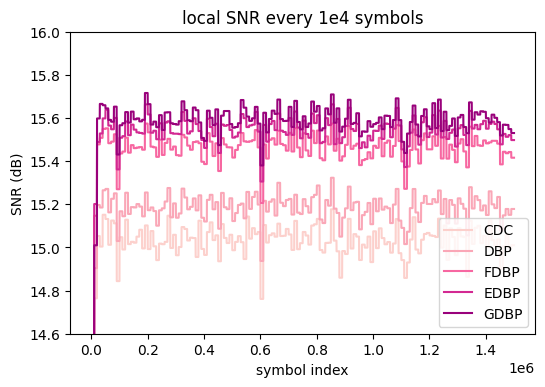

In [7]:
import matplotlib.pyplot as plt

labels = ['CDC', 'DBP', 'FDBP', 'EDBP', 'GDBP']
colors = plt.cm.RdPu(np.linspace(0.2, 0.8, len(labels)))

fig = plt.figure(dpi=100)
for r, l, c in zip(results, labels, colors):
  plt.plot(r, label=l, color=c)
plt.title('local SNR every 1e4 symbols')
plt.xlabel('symbol index')
plt.ylabel('SNR (dB)')
plt.ylim([14.6, 16.])
plt.legend(loc='lower right')